 **Atividade 3 - Hamilton Celerino da Fonseca Neto**

#Import e Dataset

In [26]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [27]:
import kagglehub

path = kagglehub.dataset_download("spscientist/students-performance-in-exams")
print("Path:", path)

df = pd.read_csv(path + "/StudentsPerformance.csv")
df.head()


Using Colab cache for faster access to the 'students-performance-in-exams' dataset.
Path: /kaggle/input/students-performance-in-exams


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


# Criando variável

In [28]:
print("Performance baseadas na média: 0 → baixa (≤ 50); 1 → média (≤ 75); 2 → alta (> 75)")

df['avg_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)

def classify(score):
    if score <= 50:
        return 0
    elif score <= 75:
        return 1
    else:
        return 2

df['performance'] = df['avg_score'].apply(classify)

df[['math score', 'reading score', 'writing score', 'avg_score', 'performance']].head()


Performance baseadas na média: 0 → baixa (≤ 50); 1 → média (≤ 75); 2 → alta (> 75)


,math score,reading score,writing score,avg_score,performance
0,72,72,74,72.666667,1
1,69,90,88,82.333333,2
2,90,95,93,92.666667,2
3,47,57,44,49.333333,0
4,76,78,75,76.333333,2


# Seleção de Features

In [29]:
X = df[['reading score', 'writing score']].values.astype(np.float32)
Y = df['performance'].values.astype(np.int64)

print(X.shape, Y.shape)


(1000, 2) (1000,)


# Normalização

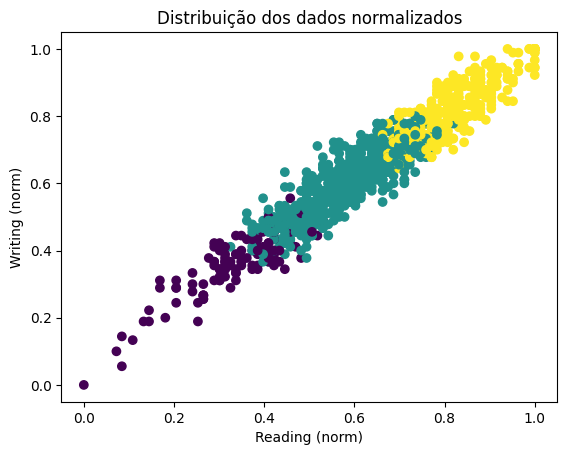

In [30]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

plt.scatter(X_norm[:,0], X_norm[:,1], c=Y, cmap='viridis')
plt.xlabel("Reading (norm)")
plt.ylabel("Writing (norm)")
plt.title("Distribuição dos dados normalizados")
plt.show()


#Treinamento

In [31]:
x_train, x_test, y_train, y_test = train_test_split(
    X_norm, Y, test_size=0.2, random_state=42, stratify=Y)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)


(800, 2) (200, 2)
(800,) (200,)


In [32]:
X_train_tensor = torch.FloatTensor(x_train)
Y_train_tensor = torch.LongTensor(y_train)

X_test_tensor = torch.FloatTensor(x_test)
Y_test_tensor = torch.LongTensor(y_test)

X_train_tensor[:5], Y_train_tensor[:5]


(tensor([[0.6386, 0.6222],
         [0.4819, 0.5778],
         [0.8193, 0.8444],
         [0.7470, 0.8222],
         [0.4578, 0.4222]]),
 tensor([1, 1, 2, 2, 1]))

# Regressão Logística Multiclasse

In [33]:
model = nn.Linear(2, 3)
model


Linear(in_features=2, out_features=3, bias=True)

In [34]:
out = model(X_train_tensor[:4])
out


tensor([[-0.0115,  0.7459,  0.2307],
        [ 0.0020,  0.7464,  0.2511],
        [-0.0518,  0.8527,  0.0960],
        [-0.0453,  0.8519,  0.1066]], grad_fn=<AddmmBackward0>)

In [35]:
probs = F.softmax(out, dim=1)
preds = torch.max(probs, dim=1)[1]

probs, preds


(tensor([[0.2269, 0.4840, 0.2891],
         [0.2279, 0.4797, 0.2924],
         [0.2160, 0.5336, 0.2504],
         [0.2166, 0.5313, 0.2521]], grad_fn=<SoftmaxBackward0>),
 tensor([1, 1, 1, 1]))

In [36]:
lr = 0.15
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

nb_epoch = 10000

losses = []
losses_test = []
acc_list = []
acc_test_list = []

for epoch in range(nb_epoch):

    output = model(X_train_tensor)
    output_test = model(X_test_tensor)

    loss = criterion(output, Y_train_tensor)
    loss_test = criterion(output_test, Y_test_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    losses_test.append(loss_test.item())

    _, pred_train = torch.max(F.softmax(output, dim=1), dim=1)
    _, pred_test = torch.max(F.softmax(output_test, dim=1), dim=1)

    acc_list.append((pred_train == Y_train_tensor).float().mean().item())
    acc_test_list.append((pred_test == Y_test_tensor).float().mean().item())

print("Final TRAIN loss:", losses[-1])
print("Final TEST loss:", losses_test[-1])


Final TRAIN loss: 0.30066806077957153
Final TEST loss: 0.2954943776130676


# Plot da Perda

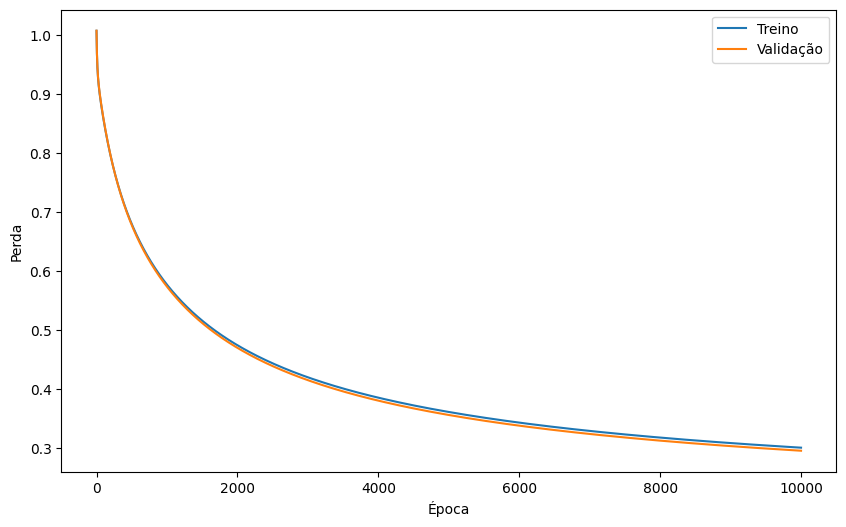

In [37]:
plt.figure(figsize=(10,6))
plt.plot(losses, label="Treino")
plt.plot(losses_test, label="Validação")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.legend()
plt.show()


# Plot da Acurácia

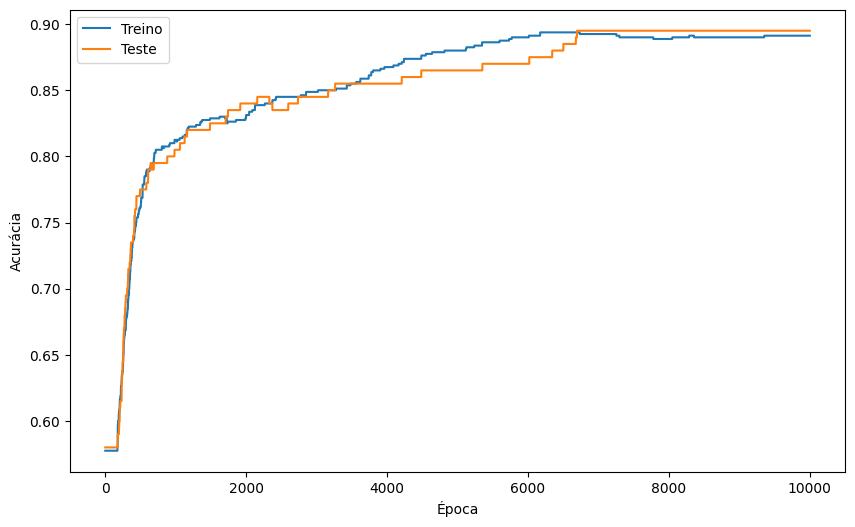

In [38]:
plt.figure(figsize=(10,6))
plt.plot(acc_list, label="Treino")
plt.plot(acc_test_list, label="Teste")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.show()


# Parâmetro pós treinamento

In [39]:
model.state_dict()


OrderedDict([('weight',
              tensor([[-9.0993, -8.8527],
                      [-2.0055,  0.7233],
                      [10.9327,  7.9629]])),
             ('bias', tensor([  9.6098,   3.1783, -11.6095]))])

# Salvar Modelo

In [40]:
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/LogReg_Students.pt")


# Carregar Modelo Salvo

In [41]:
saved_params = torch.load("models/LogReg_Students.pt")
model.load_state_dict(saved_params)
model.state_dict()


OrderedDict([('weight',
              tensor([[-9.0993, -8.8527],
                      [-2.0055,  0.7233],
                      [10.9327,  7.9629]])),
             ('bias', tensor([  9.6098,   3.1783, -11.6095]))])

# Avaliação Acurária

In [42]:
final_pred = torch.max(F.softmax(model(torch.FloatTensor(X_norm)), dim=1), dim=1)[1]

accuracy = (final_pred.numpy() == Y).mean()
print("Final Accuracy:", accuracy)


Final Accuracy: 0.892


# Matriz Confusão

In [43]:
pd.crosstab(final_pred.numpy(), Y)


col_0,0,1,2
row_0,,,
0,70,3,0
1,39,551,42
2,0,24,271


# Observando o gráfico de máxima probabilidade, responda:
a) Qual é a amostra classificada corretamente, com maior probabilidade?

b) Qual é a amostra classificada erradamente, com maior probabilidade?

c) Qual é a amostra classificada corretamente, com menor probabilidade?

d) Qual é a amostra classificada erradamente, com menor probabilidade?

In [44]:
# Cálculo das probabilidades pelo modelo treinado
probs = F.softmax(model(torch.FloatTensor(X_norm)), dim=1)

# Maior probabilidade de cada amostra (confidence)
prob_values, pred_classes = torch.max(probs, dim=1)

# Máscaras de acertos e erros
correct_mask = (pred_classes.numpy() == Y)
wrong_mask   = (pred_classes.numpy() != Y)

print("Total corretas:", correct_mask.sum())
print("Total erradas:", wrong_mask.sum())

# a) Amostra correta com MAIOR probabilidade
idx = prob_values[correct_mask].argmax().item()
sample_idx = np.where(correct_mask)[0][idx]
print("a) Correta com MAIOR prob:", sample_idx, " | prob:", prob_values[sample_idx].item())

# b) Amostra errada com MAIOR probabilidade
idx = prob_values[wrong_mask].argmax().item()
sample_idx = np.where(wrong_mask)[0][idx]
print("b) Errada com MAIOR prob:", sample_idx, " | prob:", prob_values[sample_idx].item())

# c) Amostra correta com MENOR probabilidade
idx = prob_values[correct_mask].argmin().item()
sample_idx = np.where(correct_mask)[0][idx]
print("c) Correta com MENOR prob:", sample_idx, " | prob:", prob_values[sample_idx].item())

# d) Amostra errada com MENOR probabilidade
idx = prob_values[wrong_mask].argmin().item()
sample_idx = np.where(wrong_mask)[0][idx]
print("d) Errada com MENOR prob:", sample_idx, " | prob:", prob_values[sample_idx].item())

Total corretas: 892
Total erradas: 108
a) Correta com MAIOR prob: 59  | prob: 0.998392641544342
b) Errada com MAIOR prob: 339  | prob: 0.8881020545959473
c) Correta com MENOR prob: 337  | prob: 0.5033557415008545
d) Errada com MENOR prob: 243  | prob: 0.5033557415008545


2- Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?



3- Quantas entradas e quantas saídas esta rede possui?


4- Como se pode calcular a acurácia a partir da matriz de confusão?


5- O que faz a função torch.max? Quantos parâmetros ela retorna e quais seus significados?

In [45]:
print("=== Respostas Teóricas ===")

print("\n2) Quantos parâmetros possui esta rede?")
print("Para nn.Linear(2,3):")
print("- Pesos: 3 x 2 = 6")
print("- Bias: 3")
print("Total = 9 parâmetros")

print("\n3) Quantas entradas e saídas a rede possui?")
print("- Entradas = 2")
print("- Saídas = 3 classes (Softmax)")

print("\n4) Como calcular a acurácia pela matriz de confusão?")
print("Acurácia = soma da diagonal principal / soma de todos os elementos")
print("Ou seja: acertos_totais / total_amostras")

print("\n5) O que faz torch.max?")
print("torch.max(tensor, dim=1) retorna dois valores:")
print(" - values: o valor máximo ao longo daquela dimensão (probabilidade)")
print(" - indices: o índice da posição do maior valor (classe predita)")


=== Respostas Teóricas ===

2) Quantos parâmetros possui esta rede?
Para nn.Linear(2,3):
- Pesos: 3 x 2 = 6
- Bias: 3
Total = 9 parâmetros

3) Quantas entradas e saídas a rede possui?
- Entradas = 2
- Saídas = 3 classes (Softmax)

4) Como calcular a acurácia pela matriz de confusão?
Acurácia = soma da diagonal principal / soma de todos os elementos
Ou seja: acertos_totais / total_amostras

5) O que faz torch.max?
torch.max(tensor, dim=1) retorna dois valores:
 - values: o valor máximo ao longo daquela dimensão (probabilidade)
 - indices: o índice da posição do maior valor (classe predita)


In [46]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(Y, pred_classes.numpy())
acc_from_conf = np.trace(conf_matrix) / np.sum(conf_matrix)

print("Matriz de Confusão:")
print(conf_matrix)

print("\nAcurácia calculada pela matriz:", acc_from_conf)


Matriz de Confusão:
[[ 70  39   0]
 [  3 551  24]
 [  0  42 271]]

Acurácia calculada pela matriz: 0.892
